# DHS surface interpolation

In [71]:
import os
import functions
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio

from rasterio.features import shapes
from shapely.geometry import shape, mapping

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import shutil

%load_ext autoreload

from skgstat import Variogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
#conda install scikit-gstat

### Parameters

In [73]:
#Urban surface threshold to clip out urban grids (from 0-30) on the Global Human Settlement Layer (GHSL) by the European Commission

ust = 25 # (o to 30) 0 is a totally unpopulated pixel and 30 is a totally urban pixel
target_indicator = 'rate_nutr' #Name of the indicator form the DHS cluster data to be predicted
country = 'KHM' #Three digit country code
nis_year = 2006
year = 2005 #Year of the dhs survey in use
report = {} #Dictionary to store useful variables
report_folder = os.path.join('temp_files', 'report')


In [74]:
report['Country'] = country
report['DHS survey year'] = year
report['Target Indicator'] = target_indicator
report['Urban-rural threshold'] = ust

### Preparation of Georeferenced DHS Indicator Data

In [75]:
data_folder = 'data'
gdrive_path = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1UFnD8ofHi_4YXqnGCH4FLW8bapLdp4qX' #Adjust this path to this gdrive folder: "https://drive.google.com/open?id=1UFnD8ofHi_4YXqnGCH4FLW8bapLdp4qX&usp=drive_fs"
full_panel_path = os.path.join(gdrive_path, 'DISES SIG/Dataset Information/MPI/full_panel_merged')
gdf = gpd.read_file(full_panel_path)
#Eliminate unuseful columns
gdf = gdf.drop(columns=['lc_2005', 'lc_2004', 'lc_2006', 'treat_cont'])
#LC is probably the result of averaging the land cover coding data for each 5km grid cell, so holds no valuable information for us.

In [76]:
# Variables to remove from gdf
dhs_variables = [
    "rate_cm",
    "rate_nutr",
    "rate_satt",
    "rate_educ",
    "rate_elct",
    "rate_hsg",
    "rate_wtr",
    "rate_sani",
    "rate_ckfl",
    "rate_asst"
]


## Selection and Preparation of Geospatial Covariate Layers

In [77]:
report['Covariates before filtering'] = gdf.shape[1] - 3

### Dealing with missing values

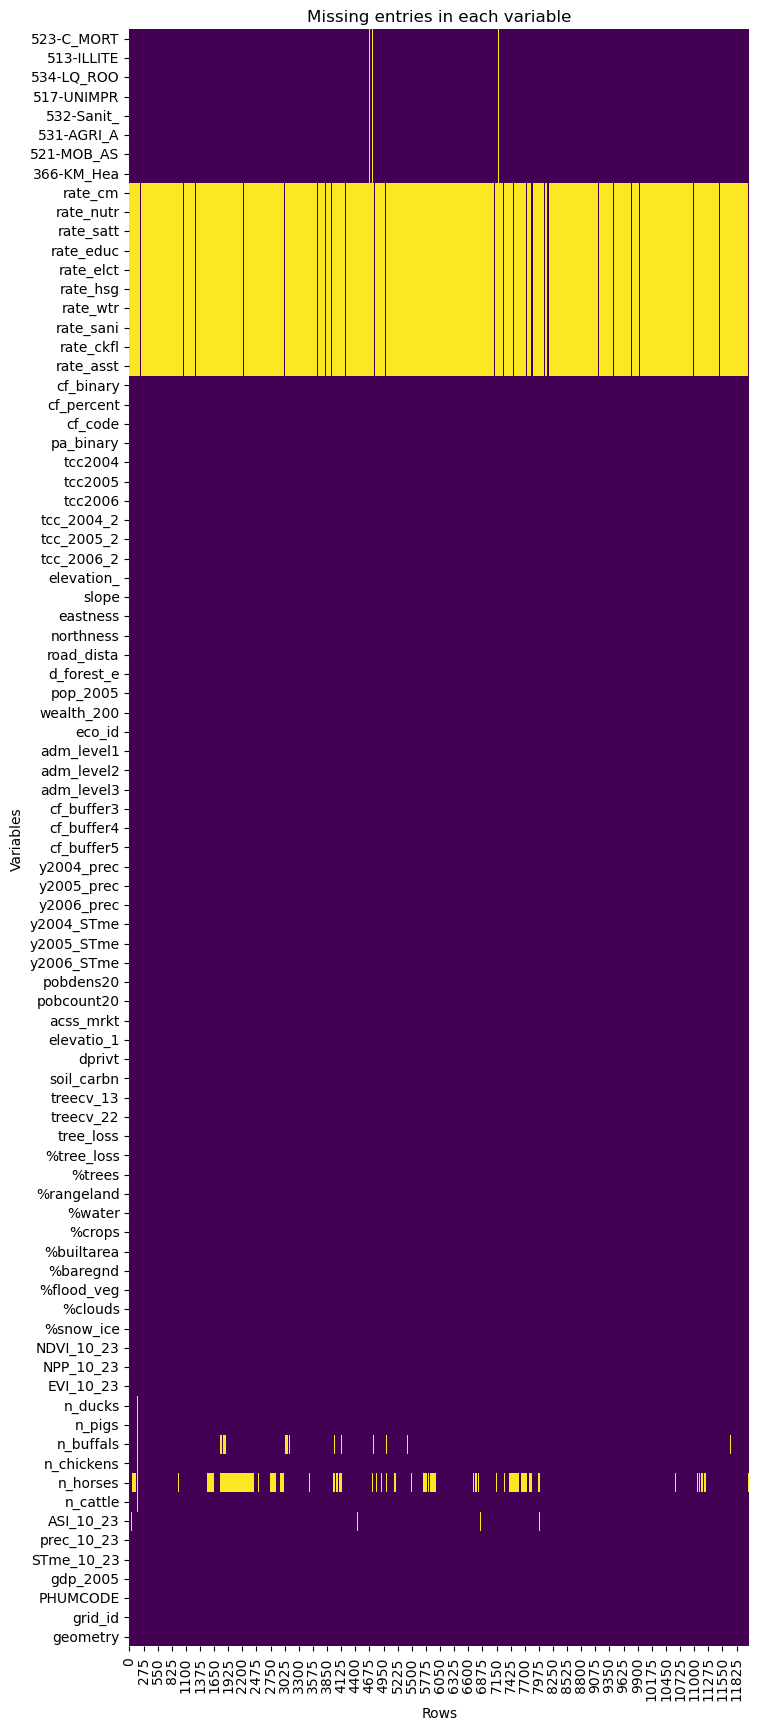

In [78]:
functions.plot_missing_values_vertical(gdf)

In [79]:
columns_with_nulls = gdf.columns[gdf.isnull().any()].tolist()

# Remove the target variable(s) if they exist in the list
for col in dhs_variables:   
    if col in columns_with_nulls:
        columns_with_nulls.remove(col)

# If you also want to exclude the target_indicator:
if target_indicator in columns_with_nulls:
    columns_with_nulls.remove(target_indicator)

In [80]:
#We perform simple interpolation of null values to keep going, but the input data should not have any. 
for column in columns_with_nulls: 
    # Perform IDW interpolation to replace null values
    gdf = functions.idw_interpolation(gdf, column)
    #gdf[column] = gdf[column].fillna(0)

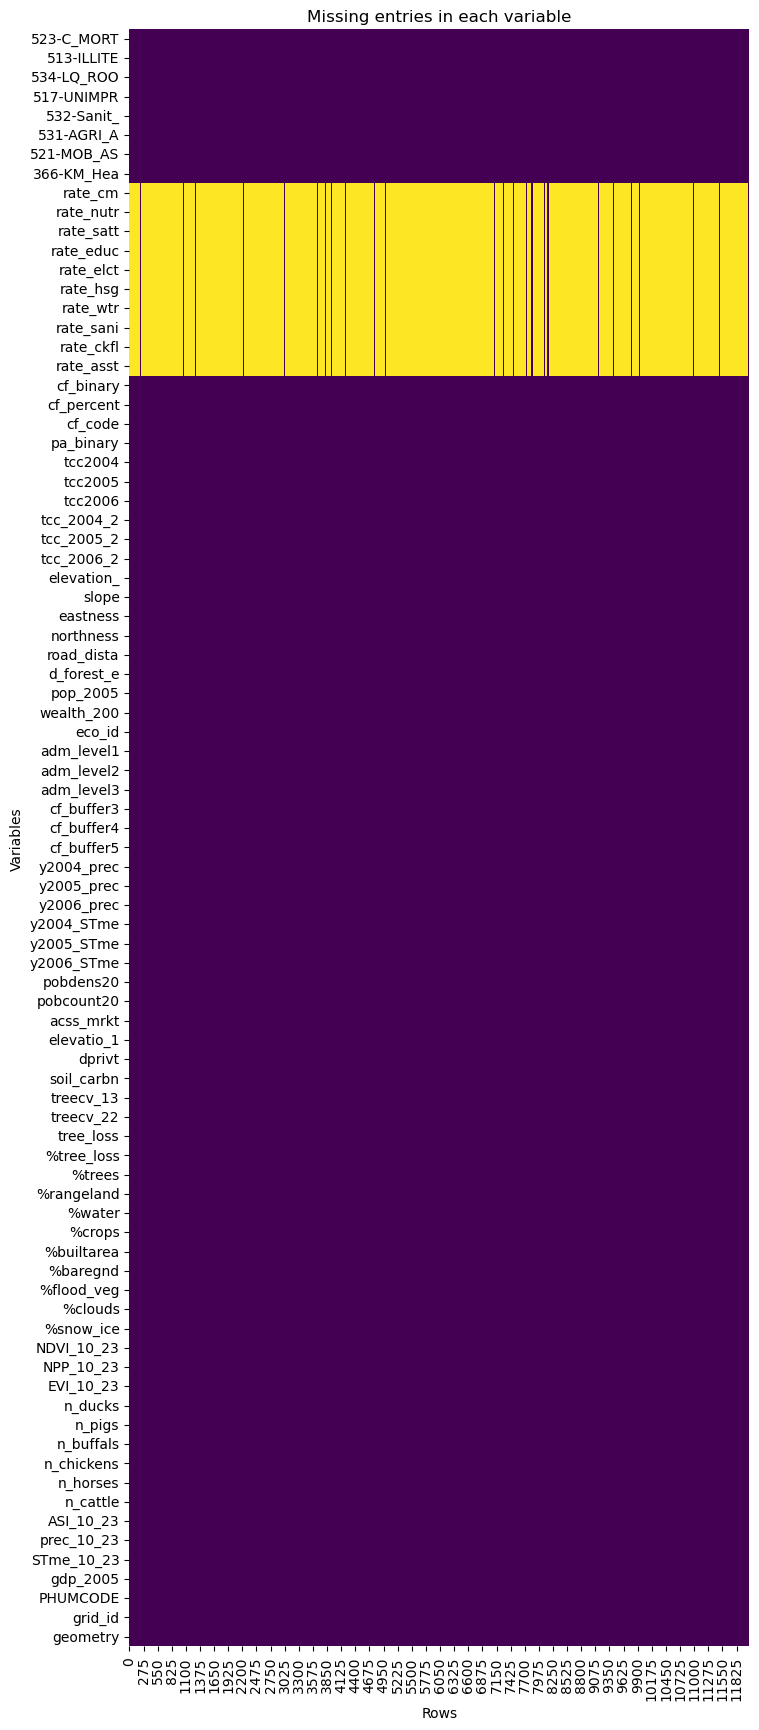

In [81]:
functions.plot_missing_values_vertical(gdf)

In [82]:
#Remove all dhs_variables except the target variable for they cannot be used in the prediction
vars_to_remove = [col for col in dhs_variables if col != target_indicator]
gdf = gdf.drop(columns=vars_to_remove)

## Exploratory Analysis of target indicator

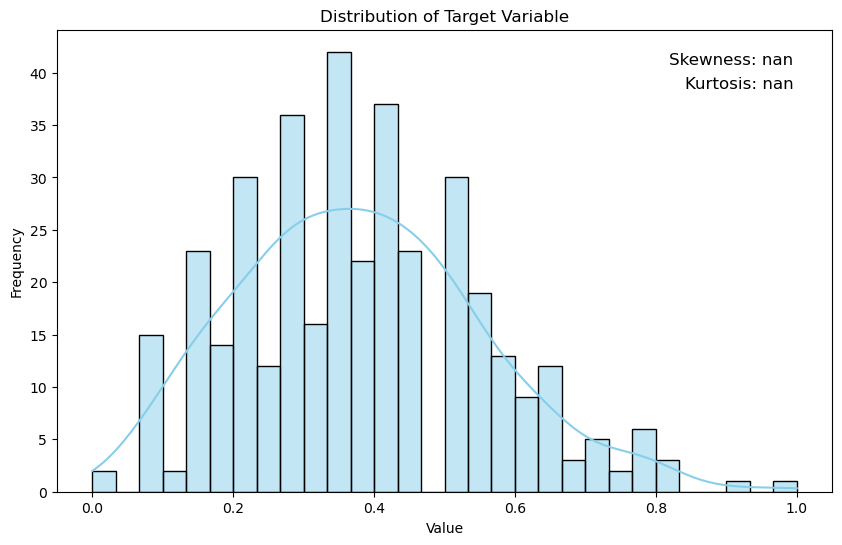

In [83]:
#There are many observations that are close to 0 in the MPI estimation.
picture_path = os.path.join(report_folder, '3. Target Distribution Before Transform.pdf')
functions.plot_distribution_with_statistics(gdf[target_indicator], picture_path)

In [84]:
t2 = gdf[target_indicator].describe()

In [85]:
t2 = pd.DataFrame(t2).reset_index()

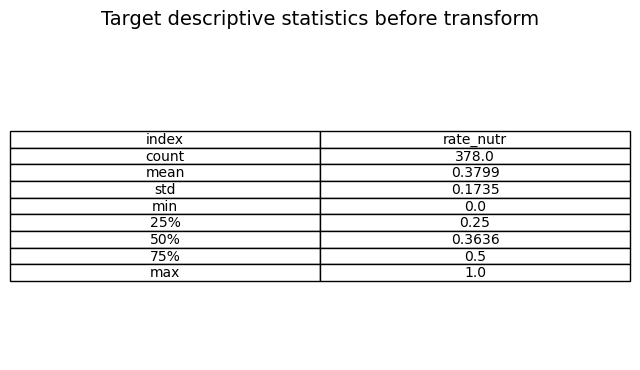

In [86]:
# Plot the DataFrame
table_path = os.path.join(report_folder, '5. Target descriptive before transform.pdf')
title = 'Target descriptive statistics before transform'
functions.df_to_pdf(t2.round(4), table_path, title=title,  show=True)

### Varioagram for the target variable

In [87]:
#Creata a gdf with only observations that are not null in the target variable
gdf1 = gdf[gdf[target_indicator].notnull()]

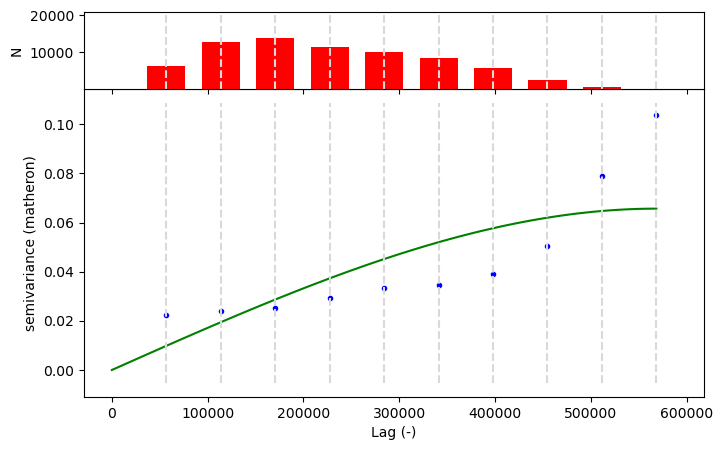

In [88]:
# Extract coordinates from the geometry column
coordinates = [(point.x, point.y) for point in gdf1.geometry]
values = gdf1[target_indicator].values

# Create and plot the variogram
variogram = Variogram(coordinates, values)
variogram.plot()

picture_path = os.path.join(report_folder, '4. Target Varioagram.pdf')
plt.savefig(picture_path)
plt.show()

### Set range value

In [89]:
# Automatically determine the range where the variogram levels off (from the model)
range_value = variogram.parameters[1]  # Extract the range from the fitted variogram model
print(range_value)

report['Variogram Range'] = np.sqrt(range_value) #The variance is in squared unites of the target indicator, so we take the sqrt.

0.06568528348000248


Interpretation of the Variogram:

A variogram describes the spatial continuity or spatial dependence of a variable. Interpretation:

    X-axis (Lag Distance):
        Represents the distance (lag) between pairs of points.
        The distance is normalized in this plot, indicated by "Lag (-)".

    Y-axis (Semivariance):
        Represents the semivariance, which measures the dissimilarity between values as a function of the lag distance.
        The semivariance typically increases with lag distance up to a certain point and then levels off.

    Empirical Semivariance Points (Blue Circles):
        Each blue circle represents the empirical semivariance for a specific lag distance.
        Calculated from the data by averaging the squared differences between all pairs of values separated by that lag distance.

    Fitted Variogram Model (Green Line):
        A model is fitted to the empirical semivariance points.
        The green line represents the theoretical variogram model that best fits the empirical data.

    Histogram of Pair Counts (Red Bars):
        The histogram at the top of the plot shows the number of point pairs used to calculate the semivariance at each lag distance.
        Provides information on the sample size for each lag, with higher bars indicating more pairs.

### Ls Beta suggestion

- Rapid correlation decay: If the correlation decays quickly (i.e., points that are relatively close to each other have low correlations), you might prefer a smaller length scale (ls). This means choosing a smaller beta in your HalfCauchy prior (e.g., beta=0.5 or beta=0.1).
- Slow correlation decay: If the correlation decays slowly (i.e., points remain correlated over longer distances), you may want a larger beta to allow for larger length scales (e.g., beta=2.0 or higher).

In [90]:
#Define a reasonable beta based on how quickly spatial corralation decays 
report['Suggested ls beta'] = functions.estimate_reasonable_beta(coordinates, values)

Min distance: 337.7106138146519
Max distance: 568300.7862565208
Mean distance: 197605.4420290401
Estimated range from variogram: 568300.7862553496
Long-range correlation detected. Setting beta to 2.0.


## Covariate Selection

- We replace the original selection with a Lasso model.
- "The goal was also to identify some variables that were likely to have strong statistical relationships with background environmental factors" (SAR 11) 

### Generate Square and Square-Root Transforms of Covariates

In [91]:
gdf1 = gdf.copy(deep=True)

In [92]:
#Exclude non-covariate columns
gdf1 = gdf1.drop(columns=[
    target_indicator,
    'geometry', 
    'grid_id', 
    'adm_level1', 
    'adm_level2', 
    'adm_level3', 
    'cf_code', 
    'PHUMCODE', 
])

In [93]:
#Apply transformation to covariates
gdf1 = functions.auto_transform(gdf1)

In [94]:
# Generate square and square-root transforms
#squared_covariates = gdf1**2
#sqrt_covariates = np.sqrt(gdf1)

# Combine all covariates into a single DataFrame
#gdf2 = pd.concat([gdf1, squared_covariates, sqrt_covariates], axis=1)
#gdf2.columns = [f'{col}_orig' for col in gdf1.columns] + \
#                         [f'{col}_squared' for col in gdf1.columns] + \
#                         [f'{col}_sqrt' for col in gdf1.columns]

In [95]:
gdf2 = gdf1.copy(deep=True)

In [96]:
#Drop the variables that generated missing values
gdf2 = gdf2.dropna(axis=1, how='any')

In [97]:
report['Covariates after square and square-root transforms'] = gdf2.shape[1]

### Generate pair-wise interactions between covariates

In [98]:
from itertools import combinations

In [99]:
# Generate all pair-wise interaction terms and collect them in a dictionary

interaction_terms = {}
for (col1, col2) in combinations(gdf2.columns, 2):
    interaction_terms[f'{col1}_x_{col2}'] = gdf2[col1] * gdf2[col2]

# Convert the dictionary to a DataFrame and concatenate with the original covariates
interaction_terms_df = pd.DataFrame(interaction_terms)

# Combine the covariates with the interaction terms
gdf3 = pd.concat([gdf2, interaction_terms_df], axis=1)


In [100]:
report['Covariates after pairwise interactions'] = gdf3.shape[1]

In [101]:
#This avoids the pairwise interactions to reduce dimensionality
gdf3 = gdf2.copy(deep=True)

### Covariates selection

### Lasso

By using Lasso regression, we can directly perform feature selection and build the multivariate model in a single step, thus simplifying the process significantly:

-   Fit Lasso model to select features and build the model (Steps 2, 4, and 5 combined)

This approach leverages Lasso's ability to handle feature selection and regularization, saving time and computational effort while ensuring an interpretable and efficient model.

In [102]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import r2_score
from scipy.stats import skew, kurtosis, boxcox

In [103]:
gdf4 = gdf[[target_indicator]].merge(gdf3, left_index=True, right_index=True, how='right')

In [104]:
#Keep only the observations that have a valid  cluster observation
gdf4 = gdf4[~gdf4[target_indicator].isnull()]

In [105]:
y = gdf4[[target_indicator]]

In [106]:
report['Target mean pre transform'] = y.values.mean()
report['Target std pre transform'] = y.values.std()

### Select the best transformation

We use Skwedness and Kurtosis criteria to select the best techinque. Strategy for Selection:

-   High Positive Skew: Apply log or square root transformation.
-   High Negative Skew: Apply square transformation (squaring the data can sometimes help with negative skew).
-   Moderate Skew: Apply Box-Cox or Yeo-Johnson transformation.
-   Low Skew and Kurtosis: No transformation or minimal transformation.

In [107]:
# Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(y)

#Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target

report['Lambda'] = lmda #Store lambda variable for some reversion processes

Skewness: 0.40561199931755204, Kurtosis: 0.04372459552329078
No transformation applied due to low skewness and non-positive values.


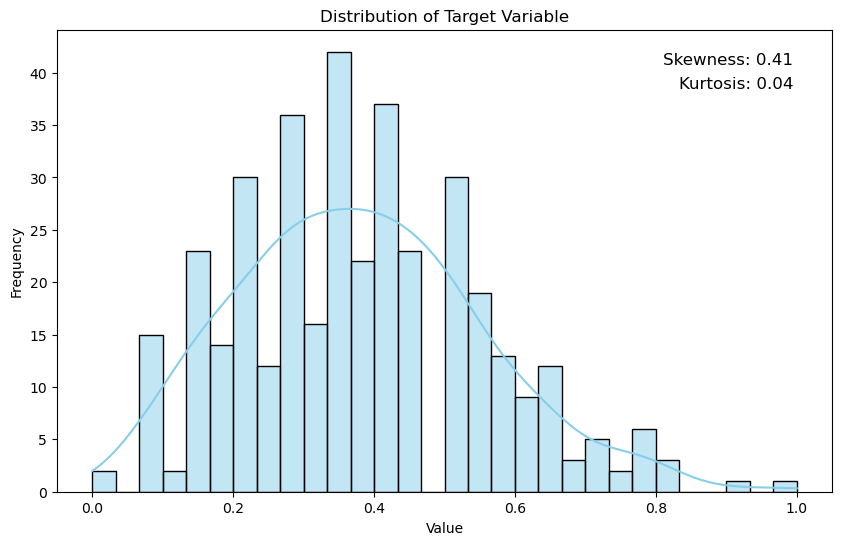

In [108]:
picture_path = os.path.join(report_folder, '6. Target transformed.png')
functions.plot_distribution_with_statistics(pd.Series(target_transformed[target_indicator]), picture_path)

In [109]:
t3 = target_transformed.describe()

In [110]:
t3 = pd.DataFrame(t3).reset_index()

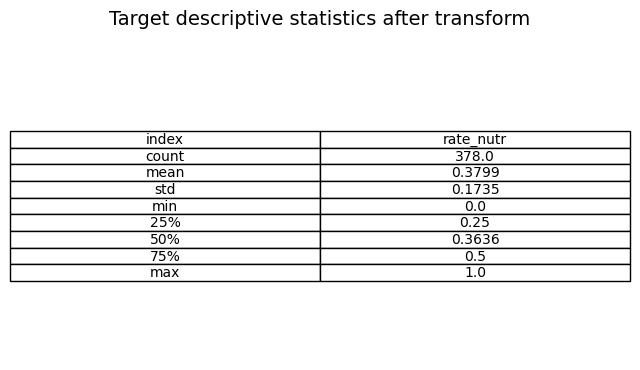

In [111]:
# Plot the DataFrame
table_path = os.path.join(report_folder, '7. Target descriptive after transform.pdf')
title = 'Target descriptive statistics after transform'
functions.df_to_pdf(t3.round(4), table_path, title=title,  show=True)

### Select covariates

In [112]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [113]:
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gdf4.drop([target_indicator, ], axis=1), target_transformed, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Fit Lasso model with cross-validation to find the best alpha
# Provide a wider alpha grid with higher regularization
alphas = np.logspace(-2.2, 2, 100)  # from 0.0001 to ~3.16
lasso = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000).fit(X_train_scaled, y_train_scaled)

#lasso = LassoCV(cv=5, random_state=42, max_iter=1000).fit(X_train_scaled, y_train_scaled)

# Get the selected features (non-zero coefficients)
selected_features = X_train.columns[(lasso.coef_ != 0)]

In [114]:
print(f'{selected_features.shape[0]} variables were selected as covariates to pass on to the Bayesian model.')

8 variables were selected as covariates to pass on to the Bayesian model.


In [115]:
report['Number of covariates selected after Lasso'] = selected_features.shape[0]

In [116]:
#Generate the final df with the mpi for export
#gdf4 = pd.concat([gdf[[target_indicator, 'geometry', 'grid_id']], gdf3[selected_features]], axis = 1)

In [117]:
gdf4 = gdf[[target_indicator, 'geometry', 'PHUMCODE']].merge(gdf3[selected_features], left_index=True, right_index=True, how='right')

In [118]:
gdf4 = gdf4[gdf4['geometry'].notnull()]

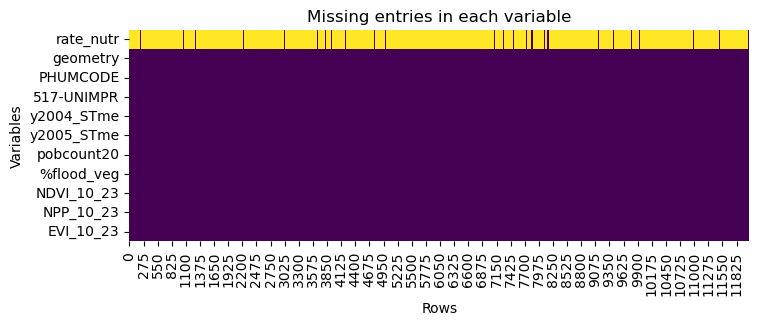

In [119]:
functions.plot_missing_values_vertical(gdf4)

In [120]:
picture_path = os.path.join(report_folder,'8. Final database chart.png')

## Transforming New Covariates data

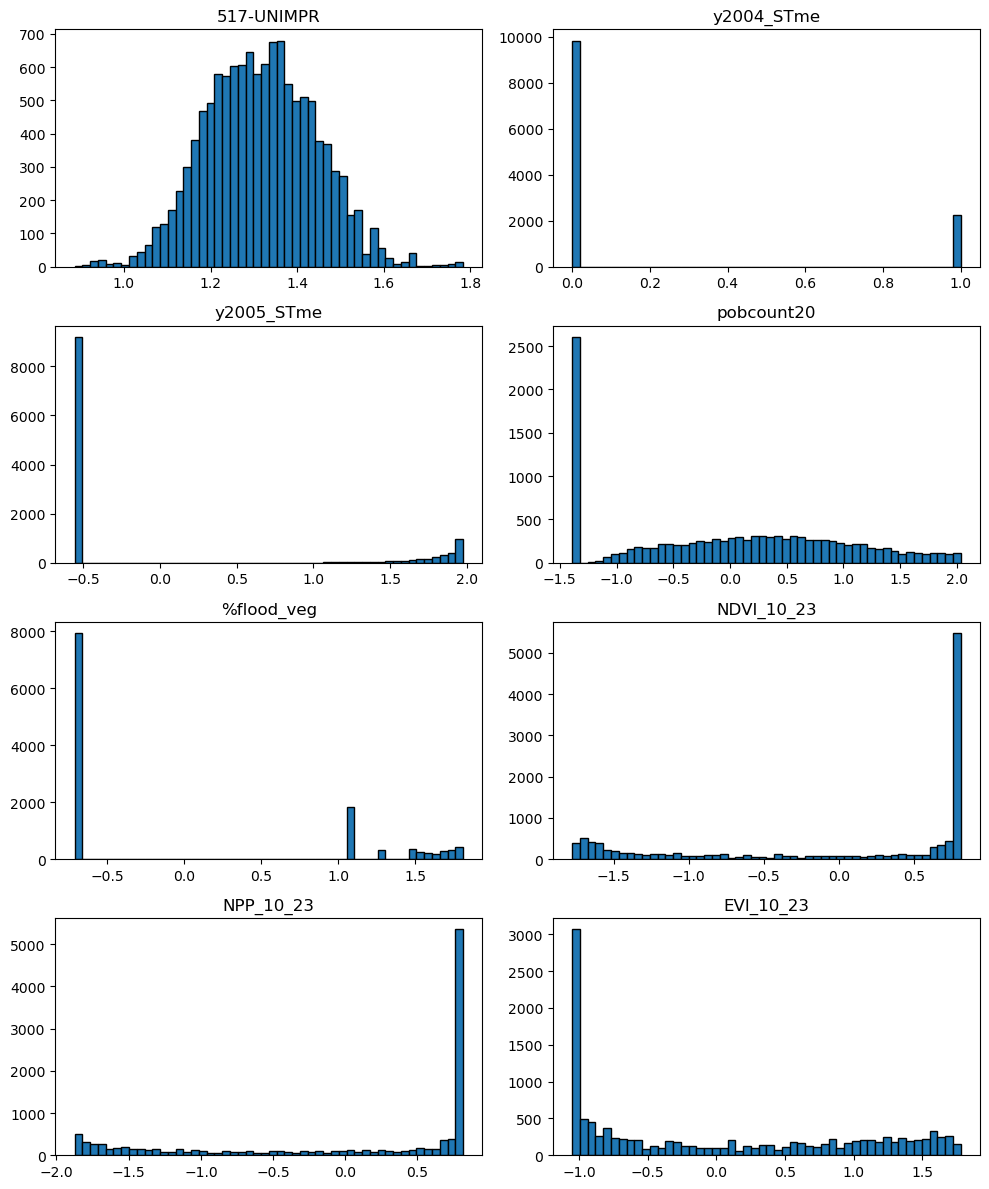

In [121]:
# Visualize distributions of covariates
functions.plot_histograms(gdf4[selected_features], bins=50)

### Save objects for MBG

In [122]:
#Save the df with selected features and with target variable
gdf4.to_pickle('temp_files/selected_features_full.pkl')

In [123]:
sample_size = int(gdf4.shape[0]*0.80)

In [124]:
#Create a sample of the data to be used for training and keep the rest for testing
gdf4 = gdf4.sample(sample_size)

In [125]:
#Save the df with selected features and with target variable
gdf4.to_pickle('temp_files/selected_features.pkl')

In [126]:
gdf4['rate_nutr'].notnull().sum()

np.int64(293)

In [127]:
t4 = pd.DataFrame(data={'Data':report.keys(), 
                  'Value': report.values()}, 
             columns=['Data','Value'])

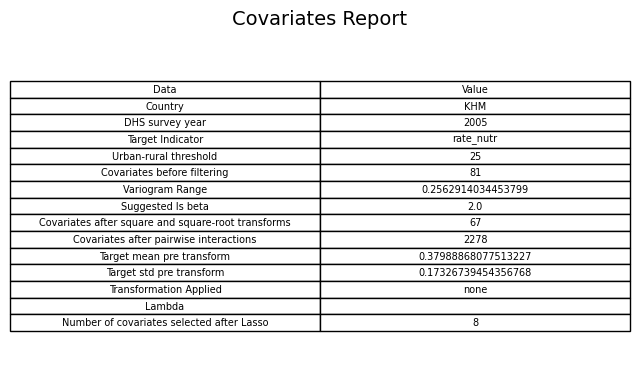

In [128]:
table_path = os.path.join(report_folder, '8. Covariates Report.pdf')
title = 'Covariates Report'
functions.df_to_pdf(t4, table_path, title=title, show=True)

In [130]:
#Save report as pickle
with open('temp_files/report/report.pkl', 'wb') as pickle_file:
    pickle.dump(report, pickle_file)